# 2023-09-08 Looking at DSS driver yielding decelerations

In [2]:
# append root folder of repo and /SCPaper to PYTHONPATH (https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
import sys
from pathlib import Path
parent_path = str(Path('.').absolute().parent)
for folder_to_add in ('', '/SCPaper'):
    path_to_add = parent_path + folder_to_add
    if not (path_to_add in sys.path):
        sys.path.append(path_to_add)
print(sys.path)

['c:\\GITHUB\\COMMOTIONSFramework\\diary notebooks', 'c:\\WinPython\\WPy64-31040-2\\python-3.10.4.amd64\\python310.zip', 'c:\\WinPython\\WPy64-31040-2\\python-3.10.4.amd64\\DLLs', 'c:\\WinPython\\WPy64-31040-2\\python-3.10.4.amd64\\lib', 'c:\\WinPython\\WPy64-31040-2\\python-3.10.4.amd64', '', 'c:\\WinPython\\WPy64-31040-2\\python-3.10.4.amd64\\lib\\site-packages', 'c:\\WinPython\\WPy64-31040-2\\python-3.10.4.amd64\\lib\\site-packages\\win32', 'c:\\WinPython\\WPy64-31040-2\\python-3.10.4.amd64\\lib\\site-packages\\win32\\lib', 'c:\\WinPython\\WPy64-31040-2\\python-3.10.4.amd64\\lib\\site-packages\\Pythonwin', 'c:\\WinPython\\WPy64-31040-2\\python-3.10.4.amd64\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\tragma\\.ipython', 'c:\\GITHUB\\COMMOTIONSFramework', 'c:\\GITHUB\\COMMOTIONSFramework/SCPaper']


Loading "c:\GITHUB\COMMOTIONSFramework\SCPaper/results/fig_4_SimResults_DSS.pkl"...
	Done.

Initial time gap 3 s:


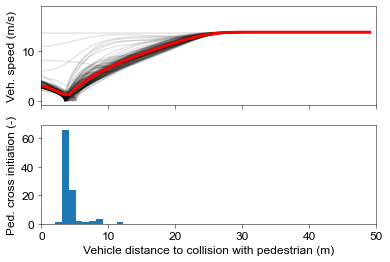


Initial time gap 5 s:


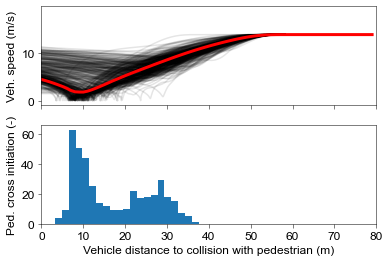


Initial time gap 7 s:


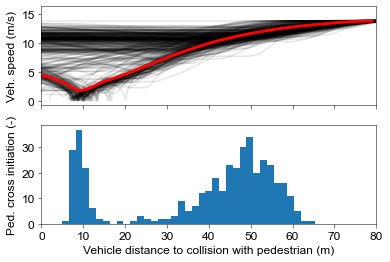

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sc_fitting, do_fig4

ZEBRA = True
GAPS = (3, 5, 7) # s
XMAXS = (50, 80, 80) # m
VEH_STOPPING_SPEED = 1 # m/s

plt.rc('font',**{'size': 12})

sim_results = sc_fitting.load_results(do_fig4.SIM_RESULTS_FNAME_DSS)
#sim_results = sc_fitting.load_results('fig_4_SimResults_DSS_saved_oDA.pkl')
n_paramets = sim_results['n_parameterisations']

for i_gap, gap in enumerate(GAPS):
    print(f'\nInitial time gap {gap} s:')
    scen_name = do_fig4.get_dss_scen_name(ZEBRA, gap)
    time_stamps = sim_results[scen_name]['time_stamps']
    veh_speeds = sim_results[scen_name][sc_fitting.i_VEH_AGENT]['speed']
    veh_cp_dists = sim_results[scen_name][sc_fitting.i_VEH_AGENT]['cp_dist']
    veh_entry_times = sim_results[scen_name][sc_fitting.i_VEH_AGENT]['entry_time']
    ped_entry_times = sim_results[scen_name][sc_fitting.i_PED_AGENT]['entry_time']
    fig, axs = plt.subplots(nrows=2, sharex=True)
    veh_cp_dists_at_ped_cross = []
    veh_speeds_at_cp_dists_list = []
    av_veh_speeds_cp_dists = np.arange(XMAXS[i_gap])
    for i_sim in range(n_paramets):
        if veh_entry_times[i_sim] > ped_entry_times[i_sim]:
            axs[0].plot(veh_cp_dists[i_sim, :], veh_speeds[i_sim, :], 'k-', alpha = 0.1)
            i_ped_entry_time_stamp = np.nonzero(time_stamps >= ped_entry_times[i_sim])[0][0]
            veh_cp_dists_at_ped_cross.append(veh_cp_dists[i_sim, i_ped_entry_time_stamp])
            if veh_speeds[i_sim, :].min() < VEH_STOPPING_SPEED:
                idx_veh_cp_dists_sorted = np.argsort(veh_cp_dists[i_sim, :])
                veh_speeds_at_cp_dists = np.interp(av_veh_speeds_cp_dists, 
                                                veh_cp_dists[i_sim, idx_veh_cp_dists_sorted], 
                                                veh_speeds[i_sim, idx_veh_cp_dists_sorted])
                veh_speeds_at_cp_dists_list.append(veh_speeds_at_cp_dists)
    veh_speeds_at_cp_dists_matrix = np.array(veh_speeds_at_cp_dists_list)
    av_veh_speeds_at_cp_dists = np.mean(veh_speeds_at_cp_dists_matrix, axis=0)
    axs[0].plot(av_veh_speeds_cp_dists, av_veh_speeds_at_cp_dists, 'r-', lw=3)
    axs[0].set_xlim(0, XMAXS[i_gap])
    axs[0].set_ylabel('Veh. speed (m/s)')
    axs[1].hist(veh_cp_dists_at_ped_cross, np.linspace(0, XMAXS[i_gap], 50))
    axs[1].set_xlabel('Vehicle distance to collision with pedestrian (m)')
    axs[1].set_ylabel('Ped. cross initiation (-)')
    plt.show()